In [5]:
import os
import matplotlib.pyplot as plt
import json
import torchmetrics
import torch
import numpy as np

import sys, os

sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from datasets.cub200 import TestDataset as CUB200TestDataset
from datasets.cars196 import TestDataset as Cars196TestDataset
from datasets.fashionmnist import TestDataset as FashionMNISTTestDataset
from datasets.mnist import TestDataset as MNISTTestDataset

In [6]:
dataset = "cub200"
basepath = f"../lightning_logs/{dataset}"

models = ["deterministic", "pfe", "laplace_posthoc_fix", "laplace_posthoc_pos", "laplace_posthoc_full",
                "laplace_online_fix", "laplace_online_pos", "laplace_online_full",
                "laplace_posthoc_arccos_pos", "laplace_posthoc_arccos_full", "laplace_posthoc_arccos_fix", 
                "laplace_online_arccos_pos", "laplace_online_arccos_full", "laplace_online_arccos_fix"]

all_data = {}
for model in models:

    all_data[model] = {}
    for seed in range(1, 6):
        if "laplace_online" in model:
            if "arccos" in model:
                path = os.path.join(basepath, "laplace_online", str(seed), "arccos", model.split("_")[-1])
            else:
                path = os.path.join(basepath, "laplace_online", str(seed), "contrastive", model.split("_")[-1])
        elif "laplace_posthoc" in model:
            if "arccos" in model:
                path = os.path.join(basepath, "laplace_posthoc", str(seed), "arccos", model.split("_")[-1])
            else:
                path = os.path.join(basepath, "laplace_posthoc", str(seed), "contrastive", model.split("_")[-1])
        else:
            path = os.path.join(basepath, model, str(seed))

        path = os.path.join(path, "results/figure_data/test_ood_curves.json")

        if not os.path.isfile(path):
            print(f"missing => {model} with seed {seed}")
            continue

        with open(path, 'r') as f:
            data = json.load(f)

        for key in data:
            if key in all_data[model]: 
                all_data[model][key] += [data[key]]
            else:
                all_data[model][key] = [data[key]]

missing => deterministic with seed 1
missing => deterministic with seed 2
missing => deterministic with seed 3
missing => deterministic with seed 4
missing => deterministic with seed 5
missing => laplace_online_fix with seed 1
missing => laplace_online_fix with seed 2
missing => laplace_online_fix with seed 3
missing => laplace_online_fix with seed 4
missing => laplace_online_fix with seed 5
missing => laplace_online_pos with seed 1
missing => laplace_online_pos with seed 2
missing => laplace_online_pos with seed 3
missing => laplace_online_pos with seed 4
missing => laplace_online_pos with seed 5
missing => laplace_online_full with seed 1
missing => laplace_online_full with seed 2
missing => laplace_online_full with seed 3
missing => laplace_online_full with seed 4
missing => laplace_online_full with seed 5
missing => laplace_online_arccos_pos with seed 1
missing => laplace_online_arccos_pos with seed 2
missing => laplace_online_arccos_pos with seed 3
missing => laplace_online_arccos_

In [7]:
data_dir = "/home/warburg/data"
if dataset == "cub200":
    dataset_id = CUB200TestDataset(data_dir)
    dataset_ood = Cars196TestDataset(data_dir)
elif dataset == "fashionmnist":
    dataset_id = FashionMNISTTestDataset(data_dir)
    dataset_ood = MNISTTestDataset(data_dir)

In [15]:
pred = np.array(all_data[model]["pred"][0])
target = pred = np.array(all_data[model]["target"][0])

idx = np.argsort(pred)
print(target[idx][:10])

idx = np.argsort(-pred)
print(target[idx][:10])

[0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1]


In [14]:
idx = np.argmax(all_data[model]["pred"][0])

all_data[model]["target"][0][idx]

0

[0 0 0 0 0]
==> low uncertainty


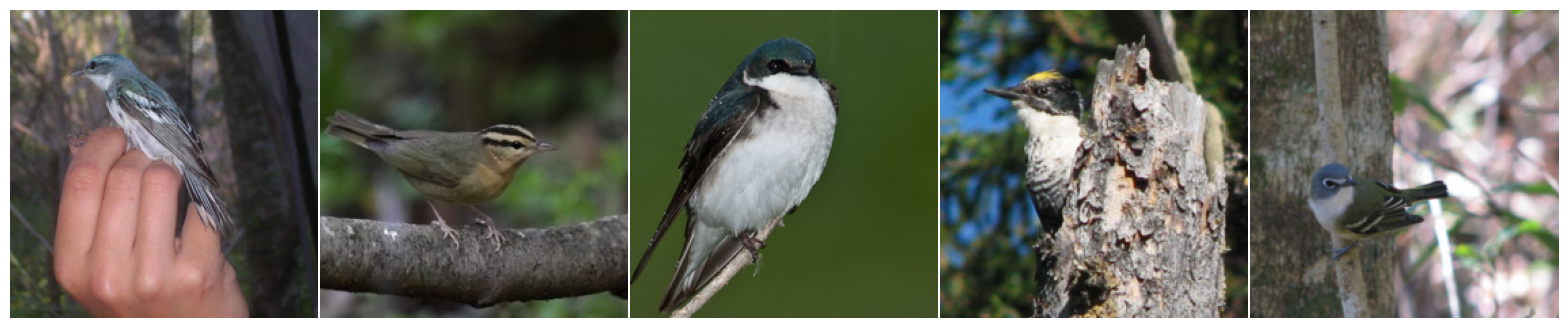

==> high uncertainty
[0 0 0 0 0]


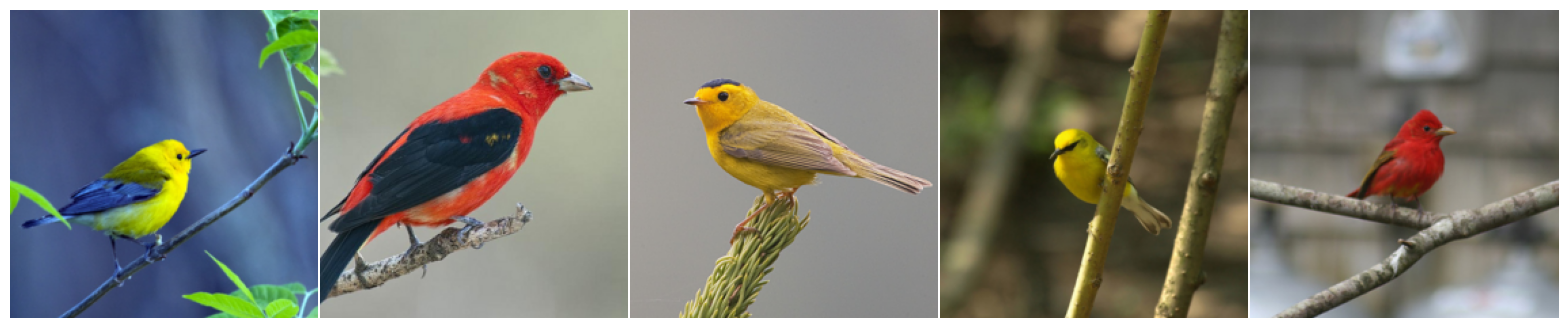

[0 0 0 0 0]
==> low uncertainty


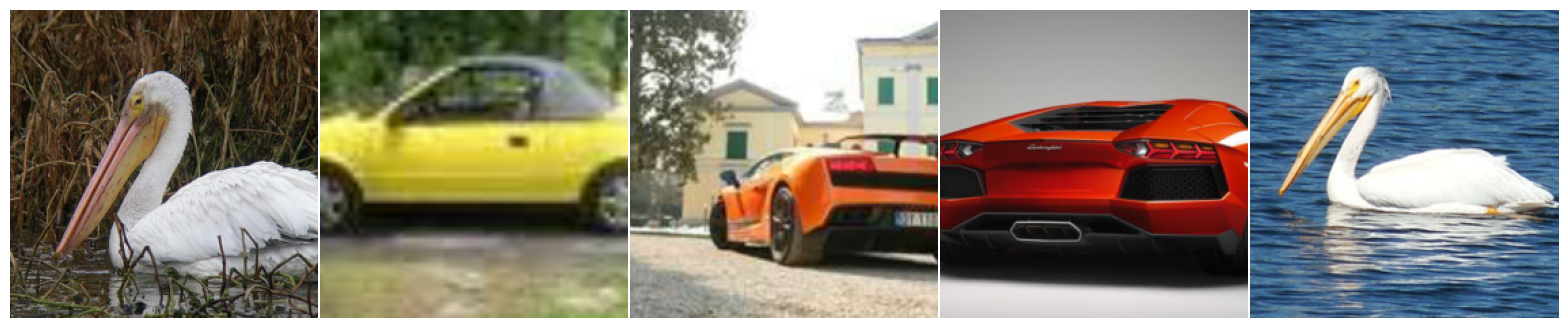

==> high uncertainty
[0 0 0 0 0]


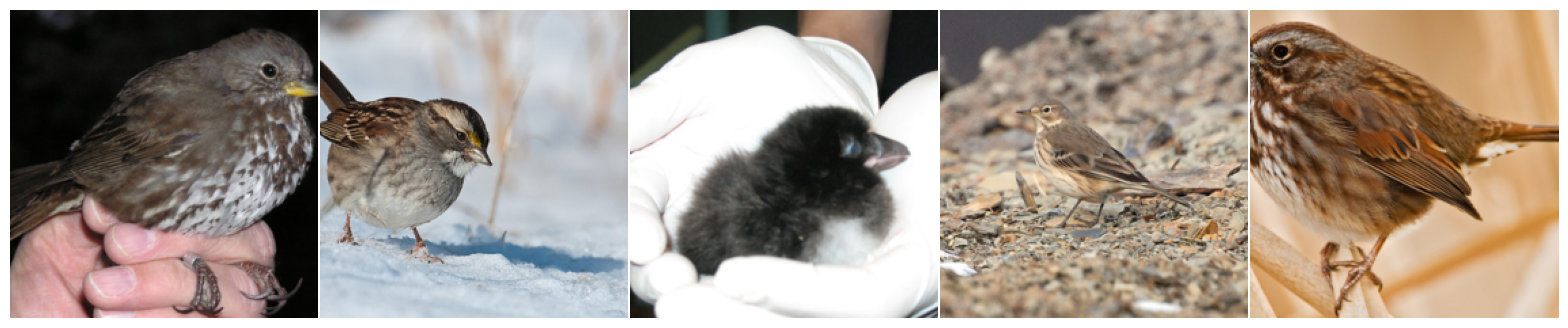

[0 0 0 0 0]
==> low uncertainty


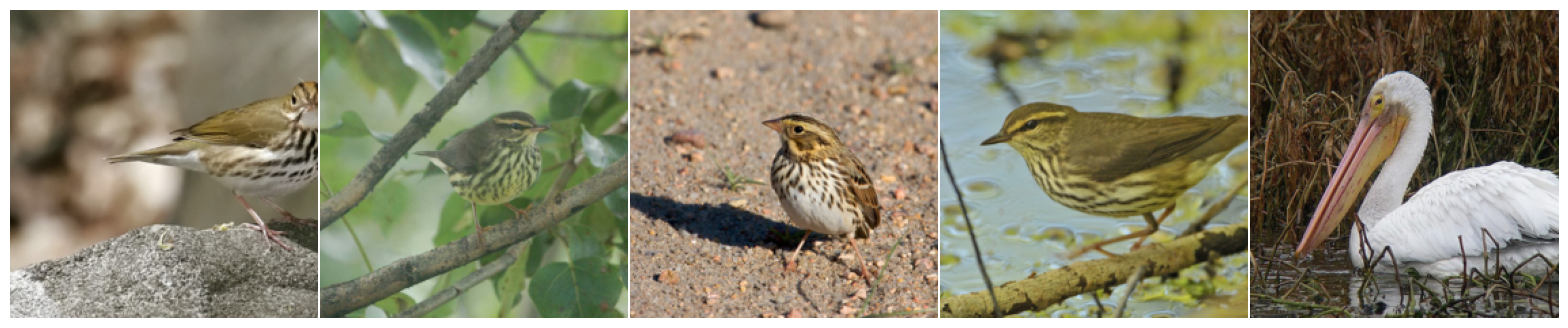

==> high uncertainty
[0 0 0 0 0]


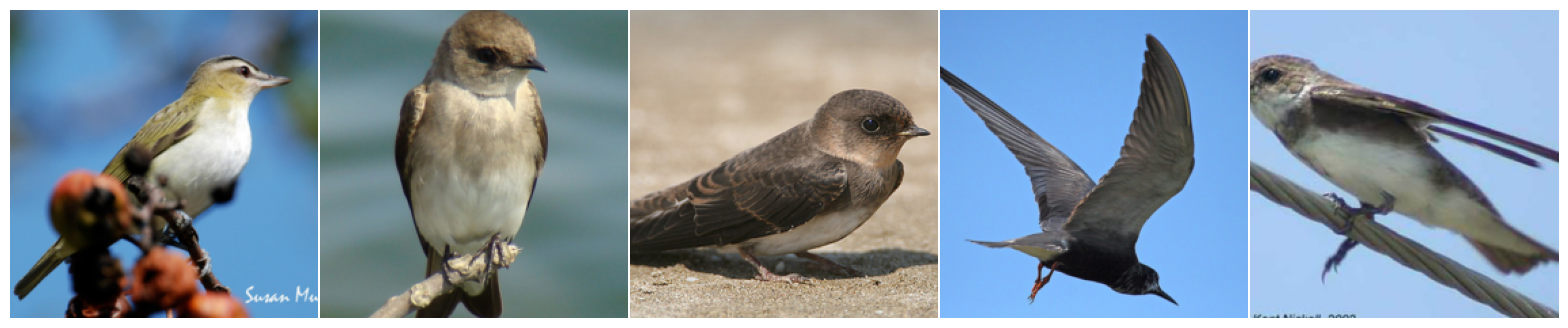

In [18]:
seed = 1
for model in ["pfe", "laplace_posthoc_arccos_fix", "laplace_online_arccos_fix"]:
    if "pred" not in all_data[model]:
        continue
    pred = all_data[model]["pred"][seed]
    target = np.array(all_data[model]["target"][seed])

    assert len(pred) == len(dataset_id) + len(dataset_ood)
    print(target[argsort_pred][:5])

    print("==> low uncertainty")
    argsort_pred = np.argsort(pred)
    assert pred[argsort_pred[0]] == np.min(pred)
    # init subplot
    fig, ax = plt.subplots(1, 5, figsize=(20, 4))
    for i in range(5):
        idx = argsort_pred[i]
        if idx < len(dataset_id):
            #print(f"ID: {model} {idx}")
            im = dataset_id.__getitem__(idx)[0]
        else:
            #print(f"OOD: {model} {idx}")
            im = dataset_ood.__getitem__(idx - len(dataset_id))[0]
        
        # unnormalize
        if dataset == "cub200":
            im = im * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        ax[i].imshow(im.permute(1, 2, 0))
        ax[i].axis('off')
        plt.subplots_adjust(wspace=0, hspace=0)

    plt.show()
    
    print("==> high uncertainty")
    argsort_pred = np.argsort(pred)[::-1]
    assert pred[argsort_pred[0]] == np.max(pred)
    # init subplot
    print(target[argsort_pred][:5])
    fig, ax = plt.subplots(1, 5, figsize=(20, 4))
    for i in range(5):
        idx = argsort_pred[i]
        if idx < len(dataset_id):
            #print(f"ID: {model} {idx}")
            im = dataset_id.__getitem__(idx)[0]
        else:
            #print(f"OOD: {model} {idx}")
            im = dataset_ood.__getitem__(idx - len(dataset_id))[0]
        
        # unnormalize
        if dataset == "cub200":
            im = im * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        ax[i].imshow(im.permute(1, 2, 0))
        ax[i].axis('off')
        plt.subplots_adjust(wspace=0, hspace=0)

    plt.show()

